In [1]:
listOfFile=["190115.tcd.csv","190122.tcd.csv","190129.tcd.csv","190205.tcd.csv","190212.tcd.csv","190219.tcd.csv",
"190226.tcd.csv","190305.tcd.csv","190312.tcd.csv","190319.tcd.csv","190402.tcd.csv","190409.tcd.csv","190416.tcd.csv",
"190423.tcd.csv","190430.tcd.csv","190507.tcd.csv","190514.tcd.csv","190521.tcd.csv","190528.tcd.csv","190604.tcd.csv",
"190611.tcd.csv","190618.tcd.csv","190625.tcd.csv","190702.tcd.csv","190709.tcd.csv","190716.tcd.csv","190723.tcd.csv",
"190730.tcd.csv","190813.tcd.csv","190820.tcd.csv","190827.tcd.csv","190903.tcd.csv","190910.tcd.csv","190917.tcd.csv",
"190924.tcd.csv","191001.tcd.csv","191008.tcd.csv","191022.tcd.csv","191029.tcd.csv","191105.tcd.csv","191112.tcd.csv",
"191119.tcd.csv","191203.tcd.csv","191210.tcd.csv","191217.tcd.csv"]

In [2]:
import pandas as pd    
import numpy as np
from matplotlib import pyplot as plt

In [3]:
sum_flow_yearly=None
for i in range(len(listOfFile)):
    df = pd.read_csv(listOfFile[i])
    #for traffic counter M1/2393A
    df_2393A=df.iloc[0:1440]
    a=df_2393A.loc[:,'Flow(Lane 1)'].to_numpy()
    b=df_2393A.loc[:,'Flow(Lane 2)'].to_numpy()
    c=df_2393A.loc[:,'Flow(Lane 3)'].to_numpy()
    d=df_2393A.loc[:,'Flow(Lane 4)'].to_numpy()
    sum_flow_daily=a+b+c+d
    if sum_flow_yearly is None:
        sum_flow_yearly=sum_flow_daily
    else:
        sum_flow_yearly=np.vstack((sum_flow_yearly,sum_flow_daily))  

In [4]:
def datacondensing(orginal,num_merge_to):
    a= orginal.shape[1]
    mergedsize=int(a/num_merge_to)
    newdataset=None
    if a%num_merge_to==0:
        for i in range (mergedsize):
            mergeddata=np.sum(orginal[:,num_merge_to*(i):num_merge_to*(i+1)], axis=1)
            if newdataset is None:
                newdataset=mergeddata
            else:
                newdataset=np.vstack((newdataset,mergeddata))
        return (newdataset.transpose())
    else:
        print ('aliquant, please choose a factor of 1440')

In [5]:
training_y = np.array([])
training_x = np.array([])
minsconsider=5
newdata=datacondensing(sum_flow_yearly,minsconsider)

for i in range (10):
    dailyflow_sample=newdata[i,:]
    training_y=np.concatenate((training_y, dailyflow_sample), axis=None)
    training_x_one= np.linspace(0, int(1440/minsconsider), int(1440/minsconsider)).reshape(-1,1)
    training_x=np.concatenate((training_x, training_x_one), axis=None)
training_x=np.transpose(np.array([training_x]))

In [6]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

X = training_x
y = training_y  

# First run
plt.figure()
kernel = 100 * RBF(length_scale=2, length_scale_bounds=(1, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+5))

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)

X_ = np.linspace(0, int(1440/minsconsider), int(1440/minsconsider))

y_gpr, y_std = gp.predict(X_[:, np.newaxis], return_std=True)


Automatically created module for IPython interactive environment


<Figure size 432x288 with 0 Axes>

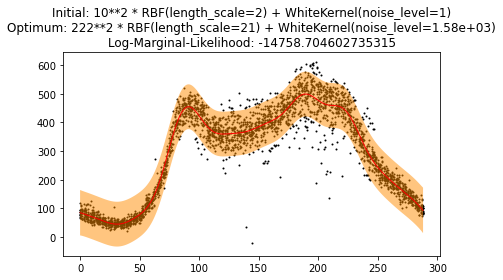

In [7]:
plt.plot(X_, y_gpr, 'r', lw=1, zorder=9)
plt.fill(np.concatenate([X_, X_[::-1]]),
         np.concatenate([y_gpr - 1.9600 * y_std ,
                        (y_gpr + 1.9600 * y_std)[::-1]]),
         alpha=.5, color='darkorange', ec='None', label='95% confidence interval')
plt.scatter(X[:, 0], y, c='b', s=1, zorder=1, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

In [8]:
newboundary=y_gpr - 2.576 * y_std
zerosnewdataset=None
filtereddata_y= np.array([])
filtereddata_x= np.array([])
for i in range (10):
    dailyflow=newdata[i,:]
    anom_day=(dailyflow>newboundary).astype(int)
    dailyflow=anom_day*dailyflow
    if zerosnewdataset is None:
        zerosnewdataset=dailyflow
    else:
        zerosnewdataset=np.vstack((zerosnewdataset,dailyflow))
    filtereddata_y=np.concatenate((filtereddata_y, dailyflow), axis=None)

In [9]:
zerodataindices=np.where(filtereddata_y == 0)[0]
filtereddata_y_nonzero = np.delete(filtereddata_y, zerodataindices)
filtereddata_x_nonzero = np.delete(training_x, zerodataindices,0)

In [10]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

X = filtereddata_x_nonzero
y = filtereddata_y_nonzero  

# First run
plt.figure()
kernel = 100 * RBF(length_scale=2, length_scale_bounds=(1, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+5))

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)

X_ = np.linspace(0, int(1440/minsconsider), int(1440/minsconsider))

y_gpr, y_std = gp.predict(X_[:, np.newaxis], return_std=True)


Automatically created module for IPython interactive environment


<Figure size 432x288 with 0 Axes>

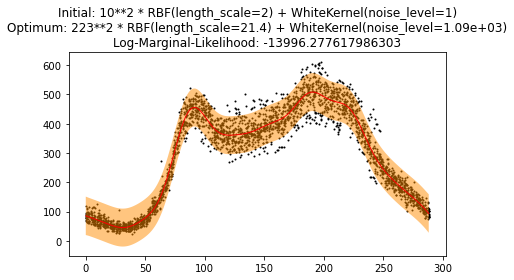

In [11]:
plt.plot(X_, y_gpr, 'r', lw=1, zorder=9)
plt.fill(np.concatenate([X_, X_[::-1]]),
         np.concatenate([y_gpr - 1.9600 * y_std ,
                        (y_gpr + 1.9600 * y_std)[::-1]]),
         alpha=.5, color='darkorange', ec='None', label='95% confidence interval')
plt.scatter(X[:, 0], y, c='b', s=1, zorder=1, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

Until here, we have mean y_gpr and vaiance: y_std^2

In [12]:
len(y_gpr)

288

In [13]:
training_y = np.array([])
training_x = np.array([])
minsconsider=5
newdata=datacondensing(sum_flow_yearly,minsconsider)

for i in range (10):
    dailyflow_sample=newdata[i,:]
    training_y=np.concatenate((training_y, dailyflow_sample), axis=None)
    training_x_one= np.linspace(0, int(1440/minsconsider), int(1440/minsconsider)).reshape(-1,1)
    training_x=np.concatenate((training_x, training_x_one), axis=None)
training_x=np.transpose(np.array([training_x]))

In [14]:
#find the residual
residual=np.zeros((10,len(y_gpr)))
zerosnewdataset=zerosnewdataset.astype('float')
zerosnewdataset[zerosnewdataset == 0] = np.nan 
for i in range (10):
    residual[i,:]=zerosnewdataset[i,:]-y_gpr
residual_new=np.nanmean(residual,axis=0,)

In [15]:
residual_new

array([ -0.07146318,   0.55122639,  -1.07796872,  -2.26840731,
         4.57205246,   2.33707616,  -3.37819319,   3.4227499 ,
        -4.76240707,  -0.63503431,  -0.39585025,   5.35474864,
        -3.6836684 ,   1.98806616,  -1.13164455,   2.75449692,
        -2.35762102,   1.42623132,  -5.6015571 ,   3.94945971,
        -0.53222886,   0.83999085,  -5.94896644,  -0.31561431,
        -3.57753717,  -1.45295684,   2.43976177,   1.88264695,
         4.95867692,   0.35233255,  -0.54987915,   3.44104309,
         4.71698246,   1.77298791,   0.20743372,   1.0220385 ,
        -0.57826774,   1.81436594,  -1.58973579,  -4.17837085,
        -3.43819076,   0.24445472,  -3.91741323,   1.08761331,
        -0.5316714 ,   1.22993735,  -0.52685452,  -4.00664001,
        -3.919961  ,  -3.78377045,  -7.52167375,  -6.86392295,
         2.95285512,  -6.01379348,   3.58867394,  17.80888661,
        14.69289611,  11.28572797,   1.53310965,   0.48332722,
        -4.31084375,   4.60980738,  -0.0871762 ,  12.07

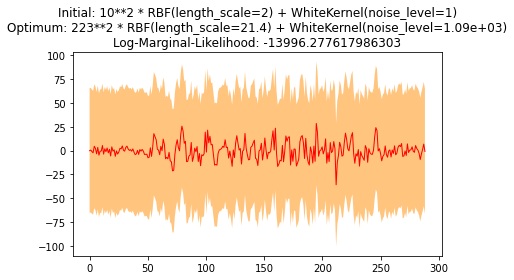

In [16]:
plt.plot(X_, residual_new, 'r', lw=1, zorder=9)

plt.fill(np.concatenate([X_, X_[::-1]]),
         np.concatenate([residual_new - 1.9600 * y_std ,
                        (residual_new + 1.9600 * y_std)[::-1]]),
         alpha=.5, color='darkorange', ec='None', label='95% confidence interval')

#plt.scatter(X[:, 0], residual, c='b', s=1, zorder=1, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

In [17]:
#GLRT
G=y_std**-2*residual_new**2

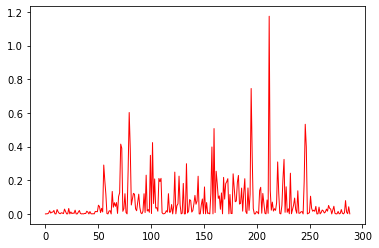

In [18]:
plt.plot(X_, G, 'r', lw=1, zorder=9)

(array([155.,  28.,  23.,  11.,  10.,  14.,   6.,   4.,   9.,   6.,   4.,
          1.,   2.,   2.,   2.,   0.,   4.,   1.,   1.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.53915123e-06, 2.34879349e-02, 4.69713306e-02, 7.04547263e-02,
        9.39381220e-02, 1.17421518e-01, 1.40904913e-01, 1.64388309e-01,
        1.87871705e-01, 2.11355101e-01, 2.34838496e-01, 2.58321892e-01,
        2.81805288e-01, 3.05288683e-01, 3.28772079e-01, 3.52255475e-01,
        3.75738870e-01, 3.99222266e-01, 4.22705662e-01, 4.46189058e-01,
        4.69672453e-01, 4.93155849e-01, 5.16639245e-01, 5.40122640e-01,
        5.63606036e-01, 5.87089432e-01, 6.10572828e-01, 6.34056223e-01,
        6.57539619e-01, 6.81023015e-01, 7.04506410e-01, 7.27989806e-01,
        7.51473202e-01, 7.74956597e-01, 7.98439993e-01, 8.21923389e-01,
        8.

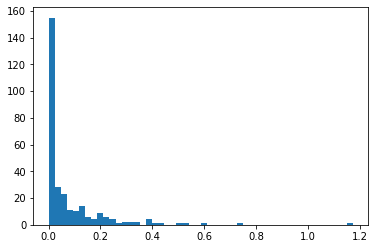

In [19]:
plt.hist(G,bins=50)

In [20]:
a=residual_new
b=y_std**2
g=b/(2*a)
h=2*a**2/b